In [1]:
import os
import sys
import numpy
import random
import math
import matplotlib
import matplotlib.pyplot
import matplotlib.colors as mcolors
import multiprocessing
import progressbar
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import spam.helpers
import spam.orientations
nProcessesDefault = multiprocessing.cpu_count()
import numpy as np
import matplotlib.pyplot as plt
import numpy
import matplotlib
import math
import matplotlib.colors as mcolors

In [2]:
def myFabricTensor(orientations):
    """
    Calculation of a second order fabric tensor from 3D unit vectors representing orientations

    Parameters
    ----------
        orientations: Nx3 array of floats
            Z, Y and X components of direction vectors
            Non-unit vectors are normalised.

    Returns
    -------
        N: 3x3 array of floats
            normalised second order fabric tensor
            with N[0,0] corresponding to z-z, N[1,1] to y-y and N[2,2] x-x

        F: 3x3 array of floats
            fabric tensor of the third kind (deviatoric part)
            with F[0,0] corresponding to z-z, F[1,1] to y-y and F[2,2] x-x

        a: float
            scalar anisotropy factor based on the deviatoric part F

    Note
    ----
        see [Kanatani, 1984] for more information on the fabric tensor
        and [Gu et al, 2017] for the scalar anisotropy factor

        Function contibuted by Max Wiebicke (Dresden University)
    """
    # from http://stackoverflow.com/questions/2850743/numpy-how-to-quickly-normalize-many-vectors
    norms = numpy.apply_along_axis(numpy.linalg.norm, 1, orientations)
    orientations = orientations / norms.reshape(-1, 1)
    # create an empty array
    N = numpy.zeros((3, 3))
    size = len(orientations)
    for i in range(size):
        orientation = orientations[i]
        tensProd = numpy.outer(orientation, orientation)
        N[:, :] = N[:, :] + tensProd
    # fabric tensor of the first kind
    N = N / size
    # fabric tensor of third kind
    F = (N - (numpy.trace(N) * (1. / 3.)) * numpy.eye(3, 3)) * (15. / 2.)
    # scalar anisotropy factor
    a = math.sqrt(3. / 2. * numpy.tensordot(F, F, axes=2))

    return N, F, a


def myDistributionDensity(F, step=50, lim=None, color=None, title=None, saveFigPath=None):
    """
    Creates the surface plot of the distribution density of the deviatoric fabric tensor F

    Parameters
    ----------
        F : 3x3 array of floats
            deviatoric fabric tensor. Usually obtained from spam.label.fabricTensor

        step : int, optional
            Number of points for the surface plot
            Default = 50

        lim : float, optional
            Limit for the axes of the plot
            Default = None

        color : colormap class, optional
            Colormap class from matplotlib module
            See 'https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html' for options
            Example : matplotlib.pyplot.cm.viridis
            Default = matplotlib.pyplot.cm.Reds

        title : str, optional
            Title for the graph
            Default = None

        saveFigPath : string, optional
            Path to save figure to.
            Default = None

    Returns
    -------
        None -- A matplotlib graph is created and shown

    Note
    ----
        see [Kanatani, 1984] for more information on the distribution density function for the deviatoric fabric tensor

    """
    #Create array of angles
    theta, phi = numpy.linspace(0, 2 * numpy.pi, step), numpy.linspace(0, numpy.pi, step)
    #Create meshgrid
    THETA, PHI = numpy.meshgrid(theta, phi)
    #Create radius array
    R = numpy.zeros(THETA.shape)
    #Copmute the radius for each angle
    for r in range(0,step,1):
        for s in range(0,step,1):
            vect = numpy.array((numpy.cos(phi[r]),
                                numpy.sin(phi[r])*numpy.sin(theta[s]),
                                numpy.cos(theta[s])*numpy.sin(phi[r])))
            R[r,s] = (1/(4*numpy.pi))*(1+numpy.dot(numpy.dot(F,vect),vect))
    #Change to cartesian coordinates
    X = R * numpy.sin(PHI) * numpy.cos(THETA)
    Y = R * numpy.sin(PHI) * numpy.sin(THETA)
    Z = R * numpy.cos(PHI)
    #Create figure
    matplotlib.rcParams.update({'font.size': 10})
    fig = matplotlib.pyplot.figure()
    ax  = fig.add_subplot( 111, projection = '3d' )
    ax.set_axis_off()
    #Set limits
    if lim == None:
        lim = round(numpy.max(R), 2)
    ax.set_xlim3d(-lim, lim)
    ax.set_ylim3d(-lim, lim)
    ax.set_zlim3d(-lim, lim)
    #Set ticks
    ax.set_xticks((-lim, 0, lim))
    ax.set_yticks((-lim, 0, lim))
    ax.set_zticks((-lim, 0, lim))
    ax.set_box_aspect((1,1,1))
    # set axis titles
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    #Title
    if title is not None:
        ax.set_title( str(title) + "\n" )
    #Colormap
    if color == None:
        cmap = matplotlib.pyplot.get_cmap(matplotlib.pyplot.cm.Reds)
    else:
        cmap = matplotlib.pyplot.get_cmap(color)
    norm = mcolors.Normalize(vmin=0, vmax=Z.max())
    #Plot
    ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, 
                           #facecolors = cmap(norm(numpy.abs(Z))),
                           #coloring by max extension
                           facecolors = cmap((R-numpy.amin(R))/numpy.amax(R-numpy.amin(R))),
                           linewidth = 0, antialiased = True, 
                           alpha = 1)

    matplotlib.pyplot.tight_layout()
    if saveFigPath is not None:
        matplotlib.pyplot.savefig( saveFigPath, dpi=200 )
    else:
        matplotlib.pyplot.show()

def difference_quaternion(q1,q2):
    q1 = q1 / np.linalg.norm(q1)
    q2 = q2 / np.linalg.norm(q2)
    cos_theta_over_2 = q1[0]*q2[0] + q1[1]*q2[1] + q1[2]*q2[2] + q1[3]*q2[3]
    if cos_theta_over_2 >= 1.: return 0
    else: return 2*np.arccos(cos_theta_over_2)*180/np.pi
    
def difference_quaternion_2(q1,q2):
    cos1 = q1[3]
    sin1 = np.sqrt(1-cos1*cos1)
    cos2 = q2[3]
    sin2 = np.sqrt(1-cos2*cos2)
    u1 = q1[:3]/sin1
    u2 = q2[:3]/sin2
    u1 = u1 / np.linalg.norm(u1)
    u2 = u2 / np.linalg.norm(u2)
    product = u1[0]*u2[0] + u1[1]*u2[1] + u1[2]*u2[2]
    if product >= 1.: return 0.
    else: return np.arccos(product) * 180. / np.pi
    
def best_fit_plane(points):
    A = points.copy()
    A[:,2] = 1
    b = points[:,2]
    w = np.linalg.inv(A.T @ A) @ A.T @ b
    e = b - A @ w
    print('residual erros {:.4f}'.format(np.linalg.norm(e)) )
    plt.figure()
    ax = plt.subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], color='b')
    res = np.array([w[0], w[1], -1])
    res = res / np.linalg.norm(res)
    height = w[2]
    return res, height

def best_fit_plane2(points):
    A = points.copy()
    plt.figure()
    ax = plt.subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], color='b')
    print( np.linalg.eig(A.T @ A) )
    
def quaternion_to_matrix(quat):
    rot_matrix = numpy.zeros((3,3))
    rot_matrix[0,0] = -quat[0]*quat[0] + quat[1]*quat[1] - quat[2]*quat[2] + quat[3]*quat[3]
    rot_matrix[0,1] = -2*( quat[0]*quat[1] - quat[2]*quat[3] )
    rot_matrix[0,2] =  2*( quat[1]*quat[2] + quat[0]*quat[3] )
    rot_matrix[1,0] = -2*( quat[0]*quat[1] + quat[2]*quat[3] )
    rot_matrix[1,1] =  quat[0]*quat[0] - quat[1]*quat[1] - quat[2]*quat[2] + quat[3]*quat[3]
    rot_matrix[1,2] = -2*( quat[0]*quat[2] - quat[1]*quat[3] )
    rot_matrix[2,0] =  2*( quat[1]*quat[2] - quat[0]*quat[3] )
    rot_matrix[2,1] = -2*( quat[0]*quat[2] + quat[1]*quat[3] )
    rot_matrix[2,2] = -quat[0]*quat[0] - quat[1]*quat[1] + quat[2]*quat[2] + quat[3]*quat[3]
    return rot_matrix

def myShearBand(all_rotations, all_positions, ns, lag, N):
    first_rot = all_rotations[(ns-1-lag)*ng:(ns-lag)*ng]
    last_rot  = all_rotations[(ns-1)*ng:ns*ng]
    last_pos  = all_positions[(ns-1)*ng:ns*ng]
    diffs = []
    for i in np.arange(ng):
        diffs.append(difference_quaternion(first_rot[i], last_rot[i]))
            

    diffs = np.array(diffs)
    m = np.mean(diffs)
    s = np.std(diffs)
    print('mean is {:.4f}, std is {:.4f}'.format(m,s))
    
    large_rotation = np.where(diffs > m + N*s)[0]
    print('#grains in shear band {}'.format(len(large_rotation)) )
    return diffs, large_rotation, last_pos

def myBestFitPlane(large_rotation, last_pos, N, n, verbose=False):
    #initial guess
    allpoints = last_pos[large_rotation]
    points = []
    for pos in allpoints:
        if abs(pos[0]) < 500. and abs(pos[1]) < 500. and pos[2] > 0. and pos[2] < 1500.:
            points.append(pos)
    points = np.array(points)
    A = points.copy()
    b = A[:,2].copy()
    A[:,2] = 1
    w = np.linalg.inv(A.T @ A) @ A.T @ b
    e = b - A @ w
    if verbose:
        print('residual erros {:.4f}'.format(np.linalg.norm(e)) )
        plt.figure()
        ax = plt.subplot(111, projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2], color='b')
    normal = np.array([w[0], w[1], -1])
    normal = normal / np.linalg.norm(normal)
    height = w[2]
    print('initial normal {}, initial height {}'.format(normal, height))
    #othorgnality pursuit    
    for step in np.arange(N):
        dist = []
        for point in points:
            dist.append( normal @ point + height )
        qualified_id = np.argsort(dist)[n:-n]
        points = points[qualified_id]
        if verbose:
            plt.figure()
            ax = plt.subplot(111, projection='3d')
            ax.scatter(points[:,0], points[:,1], points[:,2], color='b')
        A = points.copy()
        b = A[:,2].copy()
        A[:,2] = 1
        w = np.linalg.inv(A.T @ A) @ A.T @ b
        e = b - A @ w
        normal = np.array([w[0], w[1], -1])
        normal = normal / np.linalg.norm(normal)
        height = w[2]
        print('at step {}, normal {}, initial height {}, residual error {:.4f}. remain grains {}'.format(step, normal, height, np.linalg.norm(e), len(qualified_id) ))
    return normal, height

def myPlotSphericalHistogram(orientations, subDiv = 3, reflection=True, maxVal=None, verbose=True, color=None, title=None, saveFigPath=None):
    """
    Generates a spherical histogram for vectorial data, binning the data into regions defined by the faces of an icosphere (convex polyhedron made from triangles).

    The icosphere is built from starting from an icosahedron (polyhedron with 20 faces) and then making subdivision on each triangle. 
    The number of faces is  20*(4**subDiv).

    Parameters
    ----------
        orientations : Nx3 numpy array
            Vectors to be plotted

        subDiv : integer, optional
            Number of times that the initial icosahedron is divided. 
            Default: 3

        reflection : bool, optional
            If true, the histogram takes into account the reflection of the vectors
            Default = True. 

        maxVal : int, optional
            Maximum colour-bar limits for bin view.
            Default = None (`i.e.`, auto-set)

        verbose : bool, optional
            Print the evolution of the plot
            Defautl = False

        color : colormap class, optional
            Colormap class from matplotlib module
            See 'https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html' for options
            Example : matplotlib.pyplot.cm.viridis
            Default = matplotlib.pyplot.cm.viridis_r

        title : str, optional
            Title for the graph
            Default = None

        saveFigPath : string, optional
            Path to save figure to, including the name and extension of the file.
            If it is not given, the plot will be shown but not saved.
            Default = None


    Returns
    -------
        None -- A matplotlib graph is created and shown

    """
    import spam.orientations
    # Internal function for binning data into the icosphere faces

    def binIcosphere(data, icoVectors, verbose):
        # Create counts array
        counts = numpy.zeros((len(icoVectors)))
        global computeAngle
        def computeAngle(i):
                # Get the orientation vector
                orientationVect = data[i]
                # Exchange Z and X position - for plotting
                orientationVect = [orientationVect[2], orientationVect[1], orientationVect[0]]
                # Create the result array
                angle = []
                for i in range(len(icoVectors)):
                    # Compute the angle between them
                    angle.append(numpy.arccos(numpy.clip(numpy.dot(orientationVect, icoVectors[i]), -1, 1)))
                # Get the index
                minIndex = numpy.argmin(angle)
                return minIndex

        # Create progressbar
        if verbose:
            widgets = [progressbar.FormatLabel(''), ' ', progressbar.Bar(), ' ', progressbar.AdaptiveETA()]
            pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(data))
            pbar.start()
        finishedOrientations = 0
        # Run multiprocessing
        with multiprocessing.Pool(processes=nProcessesDefault) as pool:
            for returns in pool.imap_unordered(computeAngle, range(len(data))):
                # Update the progressbar
                finishedOrientations += 1
                if verbose:
                    widgets[0] = progressbar.FormatLabel("{}/{} ".format(finishedOrientations, len(data)))
                    pbar.update(finishedOrientations)
                # Get the results
                index = returns
                # Add the count
                counts[index] += 1

        return counts


    # Get number of points
    numberOfPoints = orientations.shape[0]
    # Check that they are 3D vectors
    if orientations.shape[1] != 3:
        print('\nspam.helpers.orientationPlotter.plotSphericalHistogram: The input vectors are not 3D')
        return 
    # from http://stackoverflow.com/questions/2850743/numpy-how-to-quickly-normalize-many-vectors
    norms = numpy.apply_along_axis(numpy.linalg.norm, 1, orientations )
    orientations = orientations / norms.reshape( -1, 1 )
    # Check if we can reflect the vectors
    if reflection:
        orientations = numpy.vstack([orientations, -1*orientations])
    # Create the icosphere
    if verbose:
        print('\nspam.helpers.orientationPlotter.plotSphericalHistogram: Creating the icosphere')
    icoVerts, icoFaces, icoVectors = spam.orientations.generateIcosphere(subDiv)
    # Bin the data
    if verbose:
        print('\nspam.helpers.orientationPlotter.plotSphericalHistogram: Binning the data')
    counts = binIcosphere(orientations, icoVectors, verbose = verbose)
    # Now we are ready to plot
    if verbose:
        print('\nspam.helpers.orientationPlotter.plotSphericalHistogram: Plotting')

    # Create the figure
    fig = matplotlib.pyplot.figure()
    ax = fig.gca(projection='3d')
    ax.set_axis_off()
    if color is None:
        cmap = matplotlib.pyplot.cm.viridis_r
    else:
        cmap = color
    norm = matplotlib.pyplot.Normalize(vmin=0, vmax=1)
    if maxVal is None:
        maxVal = numpy.max(counts)

    # Don't do it like this, make empty arrays!
    #points = []
    #connectivityMatrix = []

    # Loop through each of the faces
    for i in range(len(icoFaces)):
        # Get the corresponding radius
        radii = counts[i] / maxVal
        if radii != 0:
            # Get the face
            face = icoFaces[i]
            # Get the vertices
            P1 = numpy.asarray(icoVerts[face[0]])
            P2 = numpy.asarray(icoVerts[face[1]])
            P3 = numpy.asarray(icoVerts[face[2]])
            # Extend the vertices as needed by the radius
            P1 = radii*P1 / numpy.linalg.norm(P1)
            P2 = radii*P2 / numpy.linalg.norm(P2)
            P3 = radii*P3 / numpy.linalg.norm(P3)
            # Combine the vertices
            vertices = numpy.asarray([numpy.array([0,0,0]), P1, P2, P3])

            #for vertex in vertices:
                #points.append(vertex)
            #connectivityMatrix.append([len(points)-1, len(points)-2, len(points)-3, len(points)-4])

            # Add the points to the scatter3D
            ax.scatter3D(vertices[:, 0], vertices[:, 1], vertices[:, 2], s = 0)
            # Create each face
            face1 = numpy.array([numpy.array(vertices[0]), numpy.array(vertices[1]), numpy.array(vertices[2])])
            face2 = [numpy.array(vertices[0]), numpy.array(vertices[1]), numpy.array(vertices[3])]
            face3 = [numpy.array(vertices[0]), numpy.array(vertices[3]), numpy.array(vertices[2])]
            face4 = [numpy.array(vertices[3]), numpy.array(vertices[1]), numpy.array(vertices[2])]

            # Plot each face!
            ax.add_collection3d(Poly3DCollection(face1, facecolors=cmap(norm(radii)), linewidths=0.5, edgecolors='k'))
            ax.add_collection3d(Poly3DCollection(face2, facecolors=cmap(norm(radii)), linewidths=0.5, edgecolors='k'))
            ax.add_collection3d(Poly3DCollection(face3, facecolors=cmap(norm(radii)), linewidths=0.5, edgecolors='k'))
            ax.add_collection3d(Poly3DCollection(face4, facecolors=cmap(norm(radii)), linewidths=0.5, edgecolors='k'))

    #import spam.helpers
    #spam.helpers.writeUnstructuredVTK(numpy.array(points), numpy.array(connectivityMatrix), cellData={'counts': counts})
    

    # Extra parameters for the axis
    ax.set_box_aspect([1,1,1])
    matplotlib.pyplot.xlim(-1.1,1.1)
    matplotlib.pyplot.ylim(-1.1,1.1)
    ax.set_zlim(-1.1,1.1)
    ax.view_init(25, 45)
    # Set the colorbar
    norm = matplotlib.colors.Normalize(vmin=0, vmax=maxVal)
    sm = matplotlib.pyplot.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # matplotlib.pyplot.colorbar(sm, label="Counts")
    # Remove the ticks labels and lines
    ax = matplotlib.pyplot.gca()
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    for line in ax.xaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)
    # Title
    if title is not None:
        ax.set_title( str(title) + "\n" )
    matplotlib.pyplot.tight_layout()
    if saveFigPath is not None:
        matplotlib.pyplot.savefig( saveFigPath, dpi=200 )
    else:
        matplotlib.pyplot.show()



In [159]:
ng = 71692
all_rotations = numpy.loadtxt('/home/hasitha/Desktop/data/fabric/7-6B_cylinder/results/rotations_7-6B_cylinder.dat')
all_positions = numpy.loadtxt('/home/hasitha/Desktop/data/fabric/7-6B_cylinder/results/positions_7-6B_cylinder.dat')

In [82]:
#ng = 4852
#all_positions = np.loadtxt('/home/hasitha/Desktop/data/fabric/lowres_700/results/positions_lowres_700.dat')
#all_rotations = np.loadtxt('/home/hasitha/Desktop/data/fabric/lowres_700/results/rotations_lowres_700.dat')

In [168]:
ng = 19606
all_rotations = numpy.loadtxt('/home/hasitha/Desktop/data/fabric/cylinder_belgium/results/rotations_cylinder_belgium.dat')
all_positions = numpy.loadtxt('/home/hasitha/Desktop/data/fabric/cylinder_belgium/results/positions_cylinder_belgium.dat')

In [160]:
# long axis
long_axis = []
for i in np.arange(ng):
    with open('/home/hasitha/Desktop/data/fabric/7-6B_cylinder/Morphologies/morph_'+str(i+1)+'.dat', 'r') as f:
        f.readline()
        long_axis.append(np.argmax([float(i) for i in f.readline().split()]))

long_axis = np.array(long_axis)

In [166]:
# long axis
long_axis = []
for i in np.arange(ng//2):
    with open('/home/hasitha/Desktop/data/fabric/cylinder_belgium/Morphologies/morph_'+str(i+1)+'.dat', 'r') as f:
        f.readline()
        long_axis.append(np.argmax([float(i) for i in f.readline().split()]))

long_axis = np.array(long_axis)
long_axis = np.hstack((long_axis, long_axis))

In [169]:
diffs, large_rotation, last_pos = myShearBand(all_rotations, all_positions, 200, 50, 2.)

mean is 21.5033, std is 20.3273
#grains in shear band 929


In [170]:
np.savetxt('/home/hasitha/Desktop/data/fabric/cylinder_belgium/results/large_rotation.dat', large_rotation, '%d')

In [171]:
len(diffs)

19606

In [172]:
np.savetxt('/home/hasitha/Desktop/data/fabric/cylinder_belgium/results/rotation_angles.dat', diffs, '%.4f')

In [10]:
np.sort(diffs[large_rotation])[-200:]

array([ 49.29 ,  49.327,  49.443,  49.535,  49.549,  49.613,  49.664,
        49.711,  49.938,  50.051,  50.094,  50.132,  50.146,  50.187,
        50.329,  50.367,  50.574,  50.578,  50.673,  50.728,  51.102,
        51.148,  51.155,  51.284,  51.401,  51.412,  51.43 ,  51.472,
        51.531,  51.592,  51.852,  51.906,  51.929,  51.983,  52.148,
        52.166,  52.212,  52.225,  52.292,  52.301,  52.428,  52.433,
        52.486,  52.512,  52.644,  52.694,  52.805,  52.961,  53.14 ,
        53.216,  53.385,  53.4  ,  53.452,  53.867,  54.121,  54.126,
        54.247,  54.391,  54.434,  54.652,  54.724,  54.724,  54.88 ,
        55.005,  55.108,  55.267,  55.68 ,  55.981,  56.04 ,  56.164,
        56.215,  56.494,  56.578,  57.095,  57.121,  57.148,  57.209,
        57.246,  57.499,  57.59 ,  57.768,  58.017,  58.132,  58.142,
        58.469,  58.491,  58.493,  58.549,  58.861,  59.019,  59.07 ,
        59.084,  59.716,  59.792,  59.807,  59.824,  59.833,  59.955,
        60.401,  60.

In [184]:
np.mean(diffs[large_rotation])

114.42283739114973

In [338]:
np.arccos(0.95)/np.pi*180

18.194872338766785

In [339]:
np.cos(40/180.*np.pi)

0.766044443118978

In [340]:
np.sin(40/180.*np.pi)

0.6427876096865393

In [390]:
real_large = np.array([i for i in large_rotation if (i <= 8500 or i >= 10000)])

In [391]:
len(real_large)

636

In [118]:
normal, height = myBestFitPlane(real_large, last_pos, 40, 5, verbose=False)

NameError: name 'real_large' is not defined

In [597]:
shearband = []
outside = []
last_rot  = all_rotations[0*ng:1*ng]
last_pos  = all_positions[0*ng:1*ng]

for i, pos in enumerate(last_pos):
    if abs(normal @ pos + height) < 100:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
    elif abs(normal @ pos + height) > 400:
        outside.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]])
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 2803, # grains outside shearband 7564


/home/hasitha/Desktop/spam/spam/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/hasitha/Desktop/spam/spam/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


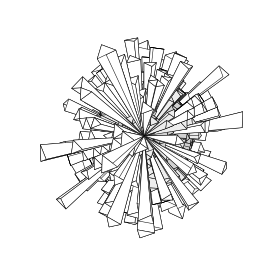

In [598]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=7, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideHist_0')

anitrosopy = 0.5182974633712398


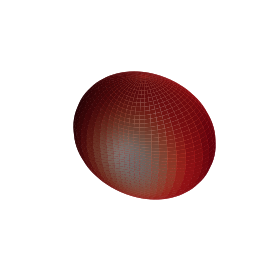

In [599]:
N, F, a = myFabricTensor(shearband)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideFabric_0')
print('anitrosopy = {}'.format(a))

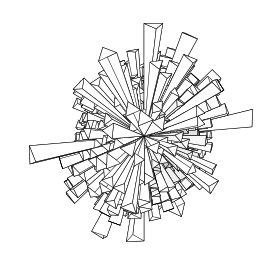

In [600]:
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=15,  saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideHist_0')

anitrosopy = 0.4804700321349426


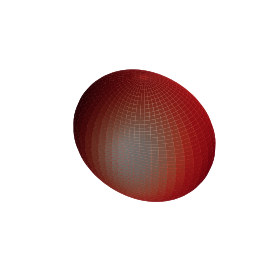

In [601]:
N, F, a = myFabricTensor(outside)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideFabric_0')
print('anitrosopy = {}'.format(a))

In [405]:
shearband = []
outside = []
last_rot  = all_rotations[20*ng:21*ng]
last_pos  = all_positions[20*ng:21*ng]

for i, pos in enumerate(last_pos):
    if abs(normal @ pos + height) < 100:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
    elif abs(normal @ pos + height) > 400:
        outside.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]])
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 2872, # grains outside shearband 7443


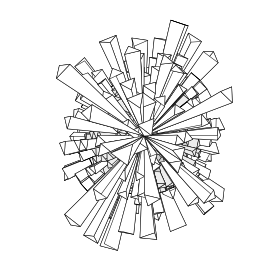

In [412]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=7, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideHist_10')

anitrosopy = 0.4182987576336036


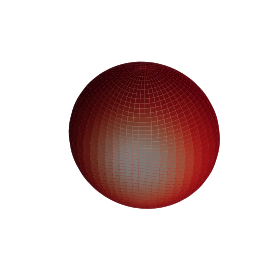

In [408]:
N, F, a = myFabricTensor(shearband)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideFabric_10')
print('anitrosopy = {}'.format(a))

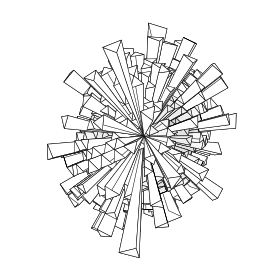

In [410]:
#myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=15)
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=15,  saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideHist_10')

anitrosopy = 0.41411208519601017


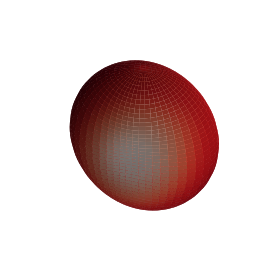

In [411]:
N, F, a = myFabricTensor(outside)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideFabric_10')
print('anitrosopy = {}'.format(a))

In [413]:
shearband = []
outside = []
last_rot  = all_rotations[40*ng:41*ng]
last_pos  = all_positions[40*ng:41*ng]

for i, pos in enumerate(last_pos):
    if abs(normal @ pos + height) < 100:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
    elif abs(normal @ pos + height) > 400:
        outside.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]])
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 2988, # grains outside shearband 7054


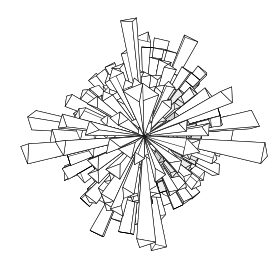

In [414]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=7, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideHist_40')

anitrosopy = 0.4527604489890759


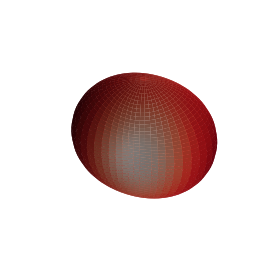

In [415]:
N, F, a = myFabricTensor(shearband)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideFabric_40')
print('anitrosopy = {}'.format(a))

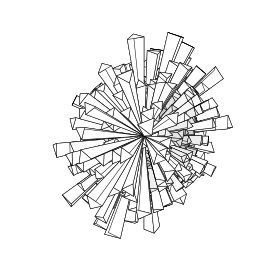

In [416]:
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=15,  saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideHist_40')

anitrosopy = 0.43291283988292995


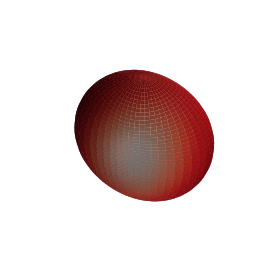

In [417]:
N, F, a = myFabricTensor(outside)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideFabric_40')
print('anitrosopy = {}'.format(a))

In [418]:
shearband = []
outside = []
last_rot  = all_rotations[80*ng:81*ng]
last_pos  = all_positions[80*ng:81*ng]

for i, pos in enumerate(last_pos):
    if abs(normal @ pos + height) < 100:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
    elif abs(normal @ pos + height) > 400:
        outside.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]])
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 3255, # grains outside shearband 6217


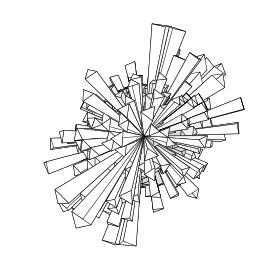

In [419]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=8, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideHist_80')

anitrosopy = 0.6878420458133874


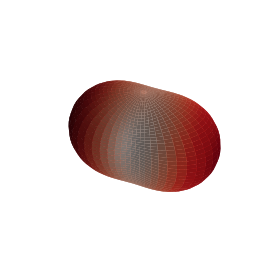

In [420]:
N, F, a = myFabricTensor(shearband)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideFabric_80')
print('anitrosopy = {}'.format(a))

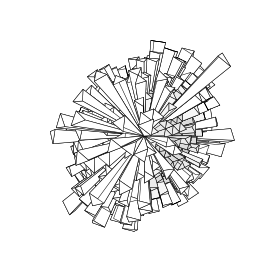

In [421]:
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=13,  saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideHist_80')

anitrosopy = 0.5234680559065105


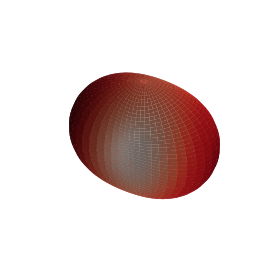

In [422]:
N, F, a = myFabricTensor(outside)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideFabric_80')
print('anitrosopy = {}'.format(a))

In [423]:
shearband = []
outside = []
last_rot  = all_rotations[120*ng:121*ng]
last_pos  = all_positions[120*ng:121*ng]

for i, pos in enumerate(last_pos):
    if abs(normal @ pos + height) < 100:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
    elif abs(normal @ pos + height) > 400:
        outside.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]])
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 3601, # grains outside shearband 5315


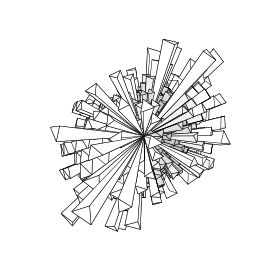

In [424]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=9, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideHist_120')

anitrosopy = 0.952529938485818


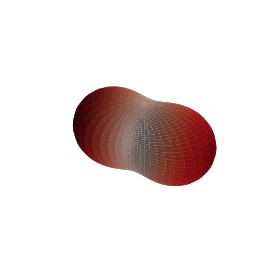

In [425]:
N, F, a = myFabricTensor(shearband)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideFabric_120')
print('anitrosopy = {}'.format(a))

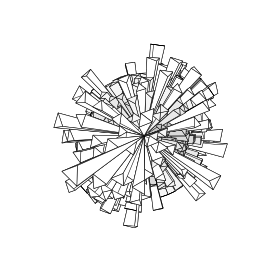

In [426]:
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=12,  saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideHist_120')

anitrosopy = 0.6049900414546939


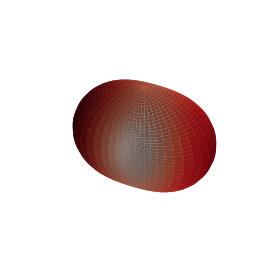

In [427]:
N, F, a = myFabricTensor(outside)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideFabric_120')
print('anitrosopy = {}'.format(a))

In [428]:
shearband = []
outside = []
last_rot  = all_rotations[158*ng:159*ng]
last_pos  = all_positions[158*ng:159*ng]

for i, pos in enumerate(last_pos):
    if abs(normal @ pos + height) < 100:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
    elif abs(normal @ pos + height) > 400:
        outside.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]])
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 3967, # grains outside shearband 4572


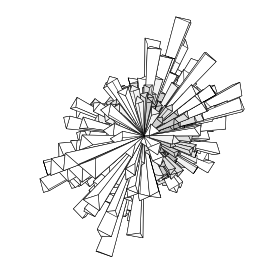

In [429]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=10, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideHist_160')

anitrosopy = 1.0458253593479834


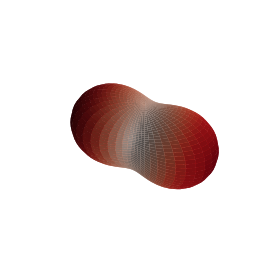

In [430]:
N, F, a = myFabricTensor(shearband)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/insideFabric_160')
print('anitrosopy = {}'.format(a))

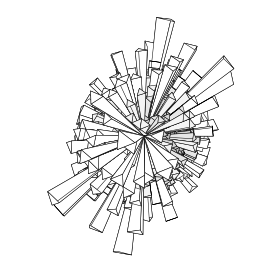

In [431]:
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False, maxVal=11,  saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideHist_160')

anitrosopy = 0.6499311123563337


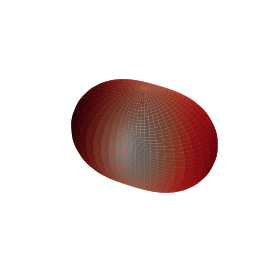

In [432]:
N, F, a = myFabricTensor(outside)
myDistributionDensity(F, saveFigPath='/home/hasitha/Desktop/data/fabric/cylinder_belgium/shearband/outsideFabric_160')
print('anitrosopy = {}'.format(a))

In [586]:
forces = []

with open('/home/hasitha/Desktop/data/fabric/cylinder_belgium/results/posChain_cylinder_belgium_159.dat', 'r') as file:
    N = int(file.readline())
    for _ in np.arange(N):
        forces.append([ float(i) for i in file.readline().split()])
    
forces = np.array(forces)
    

normal = np.array([0.335, -0.31,  -0.89])
height = 600

shearband = []
outside = []

for i, force in enumerate(forces):
    pos1 = force[:3]
    pos2 = force[3:]
    n = pos1 - pos2
    if abs(normal @ pos1 + height) < 100:
        shearband.append(n)
    elif abs(normal @ pos1 + height) > 400:
        outside.append(n)
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 6679, # grains outside shearband 7832


/home/hasitha/Desktop/spam/spam/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/hasitha/Desktop/spam/spam/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


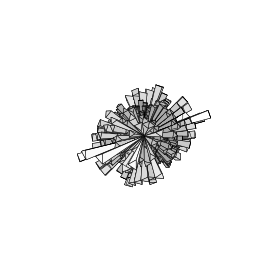

In [587]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False)

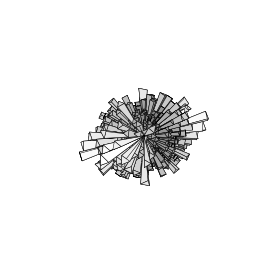

In [588]:
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False)

In [592]:
forces = []

with open('/home/hasitha/Desktop/data/fabric/cylinder_belgium/results/posChain_cylinder_belgium_119.dat', 'r') as file:
    N = int(file.readline())
    for _ in np.arange(N):
        forces.append([ float(i) for i in file.readline().split()])
    
forces = np.array(forces)
    

normal = np.array([0.335, -0.31,  -0.89])
height = 600

shearband = []
outside = []

for i, force in enumerate(forces):
    pos1 = force[:3]
    pos2 = force[3:]
    n = pos1 - pos2
    n = n/np.linalg.norm(n)
    if abs(normal @ pos1 + height) < 100:
        shearband.append(n)
    elif abs(normal @ pos1 + height) > 400:
        outside.append(n)
            
"""
for i in np.arange(ng):
    if i in large_rotation:
        shearband.append(quaternion_to_matrix(last_rot[i])[:,long_axis[i]] )
"""
shearband = np.array(shearband)
outside = np.array(outside)
print('# grains inside shearband {}, # grains outside shearband {}'.format(len(shearband), len(outside)) )

# grains inside shearband 6235, # grains outside shearband 9340


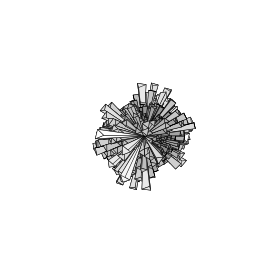

In [593]:
myPlotSphericalHistogram(shearband, color=matplotlib.pyplot.cm.Greys_r, verbose=False)

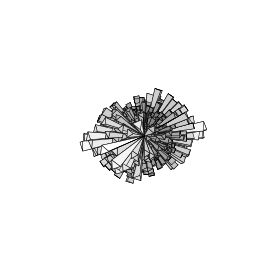

In [591]:
myPlotSphericalHistogram(outside, color=matplotlib.pyplot.cm.Greys_r, verbose=False)